In [38]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os
import numpy as np

## Data Loading

In [2]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

In [3]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [4]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            #grayscale_img = torch.tensor(grayscale_img, requires_grad=True)
            # Splitting each image vertically into 5 different parts
            for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))
            
    return data         


In [8]:
data = collect_data()

In [9]:
len(data)

4995

In [10]:
data[500]   #[0].shape

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [16., 74., 66.,  ..., 32., 44., 25.],
          [16., 74., 66.,  ..., 32., 44., 25.],
          [ 6., 26., 20.,  ...,  3.,  0.,  0.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [11]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_dataset[2]

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [29., 22.,  0.,  ..., 72., 80., 69.],
          [29., 22.,  0.,  ..., 72., 80., 69.],
          [19., 11., 15.,  ...,  0., 33.,  7.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [12]:
# Get data in dataloader format
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## First CNN

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding = "same"), nn.ReLU(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(256, 512, kernel_size = 2, padding = "same"), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(512, 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 3, padding = "same"), nn.Sigmoid(),
    
    nn.Flatten(),
    
    nn.Linear(30720, 5000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(5000, 4096), nn.Sigmoid(),
    
    nn.Linear(4096, 512), nn.Sigmoid(),
    
    nn.Linear(512, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid(),
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

'''
Trainer
'''

trainer = torch.optim.Adam(net.parameters(), lr=lr)



# Sandbox net 
## Do whatever you want with this

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net1 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=2, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=2, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 128, kernel_size = 2, padding = "same"), nn.Dropout(0.1), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(256, 1024, kernel_size = 2, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(122880, 20000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(512, 128), nn.ReLU(),
    
    nn.Linear(128, 10), nn.ReLU()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net1.parameters(), lr=lr)



In [13]:
'''
Parameters
'''

epochs = 5
lr = 0.1
batch_size = 10

'''
Net

'''

net2 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=4, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=4, stride=4),

    nn.Conv2d(16, 32, kernel_size=4, padding = "same"), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=4, stride=4),
    
    nn.Conv2d(32, 64, kernel_size =4, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=4, stride = 4),
    
    #nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    #nn.MaxPool2d(kernel_size =2, stride = 2),
    
    #nn.Conv2d(256, 512, kernel_size = 3, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.AvgPool2d(kernel_size = 2, stride = 3),
    
    #nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    #nn.Linear(9216, 4096), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(4096, 1024), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(1024, 512), nn.Dropout(0.2), nn.Sigmoid(),
    
    nn.Linear(192, 128), nn.ReLU(), 
    
    nn.Linear(128, 64), nn.ReLU(),
    
    nn.Linear(64, 32), nn.ReLU(),
    
    nn.Linear(32, 10), nn.Sigmoid()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net2.parameters(), lr=lr)



In [18]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

### One Observation

# This doesn't work for `net1` but it still manages to train idk

In [19]:
'''
One observation
'''

for layer in net2:
    obs = layer(obs)
    print(layer.__class__.__name__,'output shape: \t',obs.shape)

Conv2d output shape: 	 torch.Size([1, 16, 217, 335])
Sigmoid output shape: 	 torch.Size([1, 16, 217, 335])
MaxPool2d output shape: 	 torch.Size([1, 16, 43, 67])
Conv2d output shape: 	 torch.Size([1, 32, 43, 67])
Dropout output shape: 	 torch.Size([1, 32, 43, 67])
Sigmoid output shape: 	 torch.Size([1, 32, 43, 67])
AvgPool2d output shape: 	 torch.Size([1, 32, 8, 13])
Flatten output shape: 	 torch.Size([1, 3328])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3328 and 512x128)

### Loop

loss 2.143, train acc 0.184, test acc 0.156
119.4 examples/sec on cpu


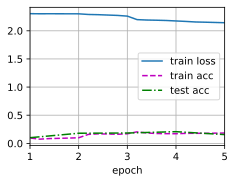

In [16]:
d2l.train_ch6(net2, train_loader, test_loader, epochs, lr, d2l.try_gpu())

In [34]:
train_loader2 = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader2 = DataLoader(test_dataset, batch_size=30, shuffle=False)

loss 1.962, train acc 0.324, test acc 0.329
116.5 examples/sec on cpu


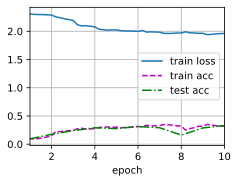

In [35]:
d2l.train_ch6(net2, train_loader2, test_loader2, epochs, lr, d2l.try_gpu())

In [93]:
raw_data = []

In [94]:
def collect_and_crop():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            data.append((grayscale_img.reshape(1,217,335), torch.tensor(class_dict.get(genre))))
            
    return data 

In [95]:
raw_data = collect_and_crop()

In [96]:
len(raw_data)

999

In [7]:
import torchvision.transforms as transforms

# Define a transform that applies random cropping to the images
crop_transform = transforms.RandomCrop(size=(128, 128))

# Apply the transform to your training dataset
augmented_dataset = []
for image, label in raw_data:
    cropped_images = [crop_transform(image) for i in range(4)]
    augmented_dataset.extend([(cropped_image, label) for cropped_image in cropped_images])

NameError: name 'raw_data' is not defined

In [ ]:
len(augmented_dataset)

In [99]:
augmented_dataset[0][0].shape

torch.Size([1, 128, 128])

In [104]:
train_size = int(0.8 * len(raw_data))
test_size = len(raw_data) - train_size
train_crop_dataset, test_crop_dataset = torch.utils.data.random_split(raw_data, [train_size, test_size])

In [105]:
train_crop_loader = DataLoader(train_crop_dataset, batch_size=25, shuffle=True)
test_crop_loader = DataLoader(test_crop_dataset, batch_size=16, shuffle=False)

In [108]:
'''
Parameters
'''

epochs = 10
lr = 0.1
batch_size = 10

'''
Net

'''

cropNet = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=3, stride=3),

    nn.Conv2d(16, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=3),
    
    nn.Conv2d(32, 64, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=4, stride = 3),
    
    nn.Conv2d(64, 128, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size =2, stride = 2),
    
    #nn.Conv2d(256, 512, kernel_size = 3, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.AvgPool2d(kernel_size = 2, stride = 3),
    
    #nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    #nn.Linear(9216, 4096), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(4096, 1024), nn.Dropout(0.2), nn.ReLU(),
    
    #nn.Linear(1024, 512), nn.Dropout(0.2), nn.Sigmoid(),
    
    nn.Linear(2304, 1024), nn.ReLU(), 
    
    nn.Linear(1024, 128), nn.ReLU(),
    
    nn.Linear(128, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(cropNet.parameters(), lr=lr)

KeyboardInterrupt: 

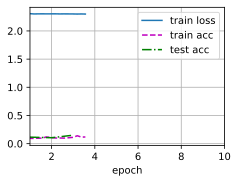

In [109]:
d2l.train_ch6(cropNet, train_crop_loader, test_crop_loader, epochs, lr, d2l.try_gpu())

In [ ]:
net1.eval()

In [52]:
test_dataset[0]

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [19., 90., 86.,  ..., 96., 95., 96.],
          [19., 90., 86.,  ..., 96., 95., 96.],
          [ 0.,  0.,  0.,  ...,  9., 16.,  8.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(5))

In [76]:
test_batch = next(iter(test_loader))

In [77]:
input_data = test_batch[0]

In [78]:
net2.eval()
with torch.no_grad():
    output = net2(input_data)

In [79]:
import numpy as np

In [80]:
output_np = output.numpy()
predicted_label = np.argmax(output_np, axis=1)

In [81]:
true_label = test_batch[1].numpy()
print("True label:      ", true_label)
print("Predicted label: ", predicted_label)

True label:       [5 3 9 4 9 0 2 5 8 0]
Predicted label:  [5 7 0 4 9 5 2 5 6 5]


# Build an MLP for the csv file

In [18]:
csv_path = "C:/Users/bbste/Documents/LSE/ST311/ST311-Group-Project/Data/features_30_sec.csv"

In [19]:
import pandas as pd

In [160]:
df = pd.read_csv(csv_path)

In [161]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [166]:
del df['filename']
del df['length']

In [167]:
df['label'] = df['label'].map(class_dict)

In [168]:
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,0
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,0
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,0
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,0
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,0


In [151]:
data = df.values

# Separate the features and labels
features = data[:, :-1]
labels = data[:, -1]

# Combine the features and labels into tuples
data_tuples = [tuple(row) for row in np.hstack((features, labels.reshape(-1, 1)))]

# Print the resulting list of tuples
print(data_tuples)


[(0.3500881195068359, 0.0887565687298774, 0.1302279233932495, 0.0028266964945942, 1784.165849538755, 129774.06452515082, 2002.4490601176965, 85882.76131549841, 3805.8396058403423, 901505.425532842, 0.0830448206689868, 0.000766945654594, -4.5297241740627214e-05, 0.0081722820177674, 7.783231922076084e-06, 0.0056981821544468, 123.046875, -113.57064819335938, 2564.20751953125, 121.57179260253906, 295.913818359375, -19.168142318725582, 235.57443237304688, 42.36642074584961, 151.10687255859375, -6.364664077758789, 167.93479919433594, 18.623498916625977, 89.18083953857422, -13.704891204833984, 67.66049194335938, 15.34315013885498, 68.93257904052734, -12.274109840393066, 82.2042007446289, 10.976572036743164, 63.38631057739258, -8.326573371887207, 61.773094177246094, 8.803791999816895, 51.24412536621094, -3.672300100326538, 41.21741485595703, 5.747994899749756, 40.55447769165039, -5.162881851196289, 49.775421142578125, 0.752740204334259, 52.4209098815918, -1.6902146339416504, 36.524070739746094

In [182]:
df['label'] = df['label'].astype(int)

In [189]:
metadata = [(list(df.loc[i][:-1]), df['label'][i]) for i in range(len(df))]

In [190]:
metadata

[([0.3500881195068359,
   0.0887565687298774,
   0.1302279233932495,
   0.0028266964945942,
   1784.165849538755,
   129774.06452515082,
   2002.4490601176965,
   85882.76131549841,
   3805.8396058403423,
   901505.425532842,
   0.0830448206689868,
   0.000766945654594,
   -4.5297241740627214e-05,
   0.0081722820177674,
   7.783231922076084e-06,
   0.0056981821544468,
   123.046875,
   -113.57064819335938,
   2564.20751953125,
   121.57179260253906,
   295.913818359375,
   -19.168142318725582,
   235.57443237304688,
   42.36642074584961,
   151.10687255859375,
   -6.364664077758789,
   167.93479919433594,
   18.623498916625977,
   89.18083953857422,
   -13.704891204833984,
   67.66049194335938,
   15.34315013885498,
   68.93257904052734,
   -12.274109840393066,
   82.2042007446289,
   10.976572036743164,
   63.38631057739258,
   -8.326573371887207,
   61.773094177246094,
   8.803791999816895,
   51.24412536621094,
   -3.672300100326538,
   41.21741485595703,
   5.747994899749756,
   40

In [194]:
np.array(metadata)

C:\Users\bbste\AppData\Local\Temp\ipykernel_3692\3393092202.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(metadata)


array([[list([0.3500881195068359, 0.0887565687298774, 0.1302279233932495, 0.0028266964945942, 1784.165849538755, 129774.06452515082, 2002.4490601176965, 85882.76131549841, 3805.8396058403423, 901505.425532842, 0.0830448206689868, 0.000766945654594, -4.5297241740627214e-05, 0.0081722820177674, 7.783231922076084e-06, 0.0056981821544468, 123.046875, -113.57064819335938, 2564.20751953125, 121.57179260253906, 295.913818359375, -19.168142318725582, 235.57443237304688, 42.36642074584961, 151.10687255859375, -6.364664077758789, 167.93479919433594, 18.623498916625977, 89.18083953857422, -13.704891204833984, 67.66049194335938, 15.34315013885498, 68.93257904052734, -12.274109840393066, 82.2042007446289, 10.976572036743164, 63.38631057739258, -8.326573371887207, 61.773094177246094, 8.803791999816895, 51.24412536621094, -3.672300100326538, 41.21741485595703, 5.747994899749756, 40.55447769165039, -5.162881851196289, 49.775421142578125, 0.752740204334259, 52.4209098815918, -1.6902146339416504, 36.524

In [192]:
metadata_train_iter, metadata_test_iter = d2l.load_array((X_train, y_train), batch_size = 25) 

ValueError: too many values to unpack (expected 2)

In [51]:
metadata_iter

In [52]:
X_train

tensor([[ 3.5009e-01,  8.8757e-02,  1.3023e-01,  ...,  5.5063e+01,
          1.2213e+00,  4.6936e+01],
        [ 3.4091e-01,  9.4980e-02,  9.5948e-02,  ...,  5.1106e+01,
          5.3122e-01,  4.5786e+01],
        [ 3.6364e-01,  8.5275e-02,  1.7557e-01,  ...,  4.6640e+01,
         -2.2313e+00,  3.0573e+01],
        ...,
        [ 4.3214e-01,  7.5268e-02,  8.1651e-02,  ...,  4.2502e+01,
         -2.1063e+00,  2.9866e+01],
        [ 3.6248e-01,  9.1506e-02,  8.3860e-02,  ...,  4.7227e+01,
         -3.5906e+00,  4.1299e+01],
        [ 3.5840e-01,  8.5884e-02,  5.4454e-02,  ...,  7.2189e+01,
          1.1552e+00,  4.9663e+01]])

In [54]:
X_train[0].shape

torch.Size([57])

In [57]:
model = nn.Sequential(
    nn.Linear(57, 32),
    nn.Sigmoid(),
    nn.Linear(32, 16),
    nn.Sigmoid(),
    nn.Linear(16, 10)
)

In [ ]:
train_size = int(0.8 * len(raw_data))
test_size = len(raw_data) - train_size
train_crop_dataset, test_crop_dataset = torch.utils.data.random_split(raw_data, [train_size, test_size])

In [ ]:
train_crop_loader = DataLoader(train_crop_dataset, batch_size=25, shuffle=True)
test_crop_loader = DataLoader(test_crop_dataset, batch_size=16, shuffle=False)